In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.imports import *
from fastai.vision import *

from torchvision.models import *
import pretrainedmodels

from utils import *
import sys

from fastai.callbacks.hooks import *

from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

In [2]:
""" Load train images metadata, Number of images we considered to train  network and how data looks"""
df_INFO = pd.read_csv('./128pix_Train30K/128px_Train30k.csv')
print(df_INFO.shape)
df_INFO.head()

(30000, 6)


,SDSS_ID,M/L,L_g,distance_Mpc,galsize_kpc,FileNames
0,1237662474235085097,1.076603,9.267565e+09,291.857134,43.540800,1237662474235085097.png
1,1237662473689956770,3.543734,5.527158e+10,661.714311,90.031951,1237662473689956770.png
2,1237662266464272761,1.080237,3.812792e+09,212.999997,25.240952,1237662266464272761.png
3,1237662305116750294,0.954058,4.078536e+09,190.714289,24.216386,1237662305116750294.png
4,1237656496724836598,4.237423,7.537444e+10,509.571433,61.791850,1237656496724836598.png


In [4]:

""" Set Base_dir to path, where train images are kept. """ 

Base_dir =f'./128pix_Train30K/'

""" List of transformation we are applying to process image"""

tfms = get_transforms(max_rotate= 20.,max_zoom=1., max_lighting=0.50, do_flip=False,
                      max_warp=0., xtra_tfms=[flip_lr(), brightness(change=(0.5, 0.70), p=0.7), contrast(scale=(0.5, 2), p=0.7),
                                              crop_pad(size=600, padding_mode='border', row_pct=0.,col_pct=0.),
                                              rand_zoom(scale=(1.,1.5)), rand_crop(),
                                              perspective_warp(magnitude=(-0.1,0.1)),
                                              #jitter(magnitude=(-0.05,0.05), p=0.5),
                                              symmetric_warp(magnitude=(-0.1,0.1)) ])

# tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0)


In [5]:
""" We have listed Base_dir, tfms(transformations) and now we are creating Data object(databunch).
    - df_INFO: A dataframe, which has file name(image name),
    - Base_dir: A variable which contains, path to read images to train network.
    - cols: A column name in dataframe df_INFO, all filenames in df_INFO are read
    
    split_by_rand :  split the images into train and validation
    label_from_df: Target column in dataframe as label and it type.
    tranform :  list of tranformation applying on each image.
    databunch:  cast it databunch type.
    normalize:  normalization with image stats"""

data_stellar_image = ImageList.from_df(df_INFO, Base_dir, cols=['FileNames']). \
                               split_by_rand_pct(0.2, seed=42). \
                               label_from_df("M/L",label_cls=FloatList). \
                               transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border',size=128). \
                               databunch(bs=128,num_workers=0).normalize(imagenet_stats)


(Image (3, 128, 128), FloatItem 2.0767674)


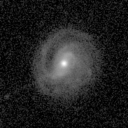

In [6]:
print(data_stellar_image.valid_ds[0])
data_stellar_image.valid_ds[0][0]

In [8]:

""" Optimizer and Loss function
    - opt_func : Adam optimizer.
    - L1LossFlat: L1 loss function"""
opt_func = partial(optim.Adam, betas=(0.9,0.99), eps=1e-5)
class L1LossFlat(nn.SmoothL1Loss):
    def forward(self, in1:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(in1.view(-1), target.view(-1))

In [10]:
""" Arch : Network achitectiure """
arch = resnet152

""" A Learner object
    cnn_learner : a callback function provided in fastai lib used to create CNN learner object.
    - data_stellar_image : a databunch object created above.
    - arch : network structure. 
    - model_dir : a path to stire cache temp results and can save model's weight.
    - pretrained :  Pretrained network. 
    - opt_func :  optimiser function. 
    - bn_wd:  backward  weight decay.
    - metric : metric to evaluate.
    - callback_fns : call back functions"""

learn = cnn_learner(data_stellar_image, arch, model_dir = "/home/ubuntu/quickstar/model513",pretrained=True ,opt_func=opt_func, bn_wd=False, metrics=root_mean_squared_error,
               callback_fns=[ShowGraph]).mixup(stack_y=False, alpha=0.2)

learn.loss_func = L1LossFlat()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 1.45E-02


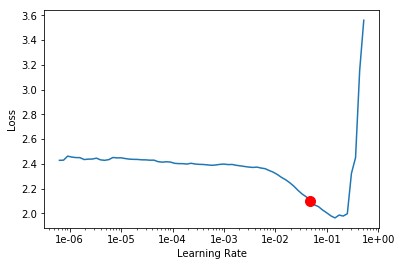

In [11]:
""" Find optimum learning rate. 
    - Since pretrained network and following ULMFit protocal to train network.
    - Freeze all layers till last layer and adjust weights of last layer.
    - find optimum learning rate by using lr_find , plot lr vs loss  to choose learning rate."""
learn.freeze_to(-1)
learn.lr_find()
learn.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,1.178416,0.573225,1.249132,07:17
1,0.565744,0.476183,1.106274,06:53
2,0.507350,0.428635,1.052678,06:54
3,0.457525,0.374137,0.979874,06:54
4,0.449397,0.337692,0.932027,06:55
5,0.402680,0.337810,0.933469,07:26
6,0.385202,0.364142,0.984901,07:31
7,0.350278,0.321154,0.914087,06:59
8,0.331949,0.312717,0.904822,06:56
9,0.319899,0.310416,0.900255,06:58


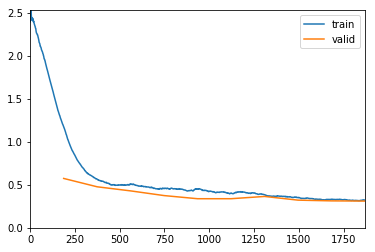

Better model found at epoch 0 with valid_loss value: 0.5732245445251465.
Better model found at epoch 1 with valid_loss value: 0.476183146238327.
Better model found at epoch 2 with valid_loss value: 0.4286354184150696.
Better model found at epoch 3 with valid_loss value: 0.37413668632507324.
Better model found at epoch 4 with valid_loss value: 0.33769193291664124.
Better model found at epoch 7 with valid_loss value: 0.32115381956100464.
Better model found at epoch 8 with valid_loss value: 0.31271740794181824.
Better model found at epoch 9 with valid_loss value: 0.3104155957698822.


In [39]:
""" Train model 
    - number of epoch.
    -  learning rate.
    - weight decay.
    - pct_start: percentage of iterations lr should rise and then decrease.
"""

learn.fit_one_cycle(10, max_lr=slice(1e-2), wd=(1e-6, 1e-4, 1e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn)])

In [12]:
""" Save the intermediate weights"""

learn.save('first_head_resnet150_614_13')
learn.load('first_head_resnet150_614_13');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 8.32E-05


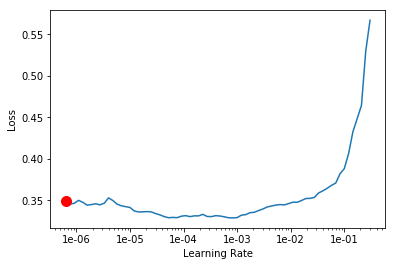

In [13]:
""" train a model 
    - unfreeze all the freezed layer during our first cycle of train, find the learning rate at this point to see what learn rate use to train
    lr_find : find learning rate, plot lr vs loss
"""
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.318258,0.440761,2.297098,07:42
1,0.305571,0.304257,0.918102,07:40
2,0.309781,0.388628,1.796258,07:39
3,0.297464,0.293384,0.889829,07:40
4,0.300138,0.296651,0.934452,08:05
5,0.297195,0.337699,1.392131,07:59
6,0.283359,0.280012,0.869843,07:41
7,0.271098,0.281351,0.861605,07:40
8,0.265345,0.268757,0.832557,07:40
9,0.257099,0.268218,0.841433,07:40


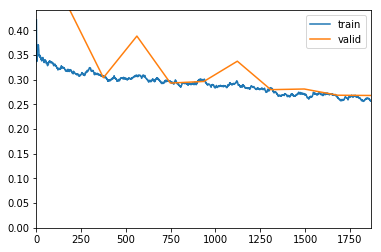

Better model found at epoch 0 with valid_loss value: 0.4407607316970825.
Better model found at epoch 1 with valid_loss value: 0.30425673723220825.
Better model found at epoch 3 with valid_loss value: 0.2933840751647949.
Better model found at epoch 6 with valid_loss value: 0.2800118625164032.
Better model found at epoch 8 with valid_loss value: 0.2687574625015259.
Better model found at epoch 9 with valid_loss value: 0.26821836829185486.


In [14]:
""" Train model 
    - number of epoch.
    -  learning rate.
    - weight decay.
    - pct_start: percentage of iterations lr should rise and then decrease.
"""
learn.fit_one_cycle(10, max_lr=slice(1e-5, 1e-4), wd=(1e-6, 1e-4, 1e-2), 
                    callbacks=[SaveModelCallback(learn)], pct_start=0.5)

In [15]:
""" Save the intermediate weights"""

learn.save('second_head_resnet150_614_14')
# learn.load('second_head_resnet150_614_14');

In [31]:
""" Save the model"""


learn.export("RESNET_STELAR_FINAL_614_best.pkl")

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type L1LossFlat. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


#### Evaluation of model on validation dataset 

In [18]:
""" Evaluate model on validation set, though model has seen the data while training to adjust it weights.
    -  first step of validating model.
    - learn.TTA() : Validation set of agumented and predicted."""


p_val, y_val = learn.TTA()

# p_val,y_val = learn.get_preds(ds_type=DatasetType.Valid)

print(p_val.shape),print(y_val.shape)

pval_numpy = p_val.numpy()
y_val_numpy =  y_val.numpy()

print(pval_numpy.shape),print(y_val_numpy.shape)

torch.Size([6000, 1])
torch.Size([6000])
(6000, 1)
(6000,)


(None, None)

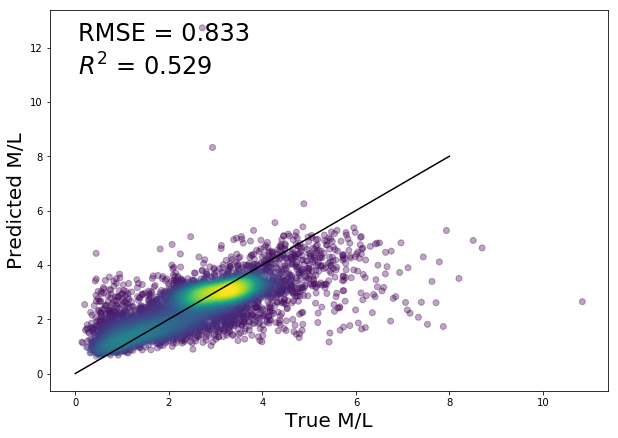

In [21]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def estimate_density(x, y, **kwargs):
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, **kwargs)
    z = kde(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    return x[idx], y[idx], z[idx]

def rmse(yt, yp):
    return np.sqrt(np.mean(np.square(yt - yp)))

def r2(yt, yp):
    ybar = np.mean(yt)
    return 1 - (np.sum(np.square(yt - yp)) / np.sum(np.square(yt - ybar)))

def plot_truevspred():
    y = y_val_numpy
    y_pred = pval_numpy[:,0]
    rmse_val = rmse(y, y_pred)
    r2_val = r2(y, y_pred)
    
    xc, yc, c = estimate_density(y, y_pred)
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['font.size'] = 10
    plt.figure(figsize=(10, 7))
    plt.scatter(xc, yc, c=c, alpha=0.35)
    plt.xlabel('True M/L')
    plt.ylabel('Predicted M/L')
    plt.plot([0, 8], [0, 8], 'k-')
    ax = plt.gca()
    fontsize = 24
    plt.text(0.05, 0.92, f'RMSE = {rmse_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    plt.text(0.05, 0.83, f'$R^2$ = {r2_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    
plot_truevspred()

### Model evaluation on test set

In [23]:

test_dir =f'./128_test5K/'

df_test =  pd.read_csv(os.path.join(test_dir,"128_test5k.csv"))

In [25]:
df_test.head()

,SDSS_ID,M/L,L_g,distance_Mpc,galsize_kpc,FileNames,FILEPATH
0,1237667323264892995,2.655465,5.694904e+10,323.571414,40.150990,1237667323264892995.png,./128_test5K/1237667323264892995.png
1,1237667322714652800,0.757768,2.382490e+09,89.999999,13.426679,1237667322714652800.png,./128_test5K/1237667322714652800.png
2,1237668310557589844,1.080746,2.730325e+09,195.857137,24.303315,1237668310557589844.png,./128_test5K/1237668310557589844.png
3,1237662226217762902,1.708090,3.609239e+10,300.428580,39.945456,1237662226217762902.png,./128_test5K/1237662226217762902.png
4,1237667211587026970,2.966155,2.124328e+10,219.857145,27.916868,1237667211587026970.png,./128_test5K/1237667211587026970.png


In [26]:
""" We have listed test_dir, tfms(transformations) and now we are creating Data object(databunch).
    - df_INFO: A dataframe, which has file name(image name),
    - Base_dir: A variable which contains, path to read images to train network.
    - cols: A column name in dataframe df_INFO, all filenames in df_INFO are read
    
    split_by_rand :  split the images into train and validation
    label_from_df: Target column in dataframe as label and it type.
    tranform :  list of tranformation applying on each image.
    databunch:  cast it databunch type.
    normalize:  normalization with image stats"""


data_test_stellar_image = ImageList.from_df(df_test, test_dir, cols=['FileNames']). \ 
                                    split_by_rand_pct(1.0, seed=42).  \ 
                                    label_from_df("M/L",label_cls=FloatList). \ 
                                    transform(tfms, resize_method=ResizeMethod.CROP, padding_mode='border',size=128). \
                                    databunch(bs=128,num_workers=0).normalize(imagenet_stats)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


In [27]:
""" Assign test databunch created to model"""

learn.data = data_test_stellar_image

In [28]:
""" Evaluate model on validation set, though model has seen the data while training to adjust it weights.
    -  first step of validating model.
    - learn.TTA() : Validation set of agumented and predicted."""


p_test, y_test = learn.TTA()

# p_val,y_val = learn.get_preds(ds_type=DatasetType.Valid)

print(p_test.shape),print(y_test.shape)

ptest_numpy = p_test.numpy()
y_test_numpy =  y_test.numpy()

print(ptest_numpy.shape),print(y_test_numpy.shape)

torch.Size([5000, 1])
torch.Size([5000])
(5000, 1)
(5000,)


(None, None)

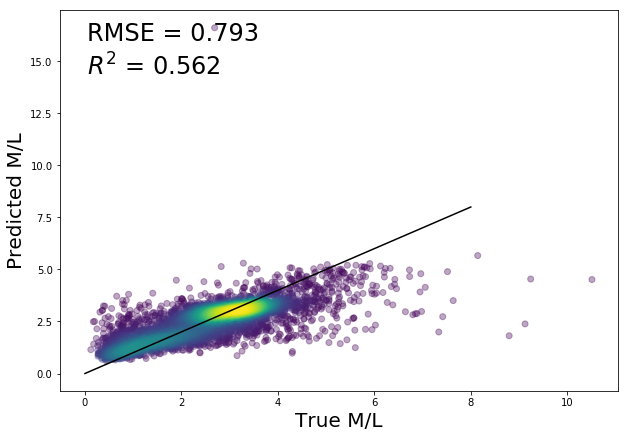

In [30]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

def estimate_density(x, y, **kwargs):
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, **kwargs)
    z = kde(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    return x[idx], y[idx], z[idx]

def rmse(yt, yp):
    return np.sqrt(np.mean(np.square(yt - yp)))

def r2(yt, yp):
    ybar = np.mean(yt)
    return 1 - (np.sum(np.square(yt - yp)) / np.sum(np.square(yt - ybar)))

def plot_truevspred():
    y = y_test_numpy
    y_pred = ptest_numpy[:,0]
    rmse_val = rmse(y, y_pred)
    r2_val = r2(y, y_pred)
    
    xc, yc, c = estimate_density(y, y_pred)
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['font.size'] = 10
    plt.figure(figsize=(10, 7))
    plt.scatter(xc, yc, c=c, alpha=0.35)
    plt.xlabel('True M/L')
    plt.ylabel('Predicted M/L')
    plt.plot([0, 8], [0, 8], 'k-')
    ax = plt.gca()
    fontsize = 24
    plt.text(0.05, 0.92, f'RMSE = {rmse_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    plt.text(0.05, 0.83, f'$R^2$ = {r2_val:.3f}', transform=ax.transAxes,
             fontsize=fontsize)
    
plot_truevspred()